```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016, 2017, 2018  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from gpuocean.SWEsimulators import FBL, CTCS, KP07, CDKLM16
from gpuocean.utils import PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from gpuocean.utils.BathymetryAndICs import *

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
#Create output directory for images
imgdir='images_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_2023_03_02-17_13_02


In [4]:

def sim_plotter(sim, T, zoom=False):
    
    sim.step(T)
    eta, hu, hv = sim.download(interior_domain_only=True)

    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(12, 8))
    
    x0, x1 =0, None
    y0, y1 =0, None
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    if zoom:
        midx = sim.nx//2 
        midy = sim.ny//2 
        x0, x1 = midx - 20, midx + 21
        y0, y1 = midy - 20, midy + 21
        domain_extent = [x0*sim.dx, x1*sim.dx, y0*sim.dy, y1*sim.dy]
    
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta[y0:y1,x0:x1], interpolation="none", origin='lower', vmin=-0.01, vmax=0.01, extent=domain_extent, cmap="coolwarm")
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(hu[y0:y1,x0:x1], interpolation="none", origin='lower', vmin=-0.05, vmax=0.05, extent=domain_extent, cmap="coolwarm")
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(hv[y0:y1,x0:x1], interpolation="none", origin='lower', vmin=-0.05, vmax=0.05, extent=domain_extent, cmap="coolwarm")
    
            

In [5]:
def crosssecs(sim):
    eta, hu, hv = sim.download(interior_domain_only=True)

    midx = sim.nx//2 
    midy = sim.ny//2 
    x0, x1 = midx - 20, midx + 21
    y0, y1 = midy - 20, midy + 21


    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].set_title("hu. Cut along y")
    axs[1].set_title("hv. Cut along x")
    for offset in [10,15,20,25]:
        axs[0].plot(hu[y0:y1, midx-offset], label=str(offset)+" cells away from center")
        axs[1].plot(hv[midy-offset, x0:x1], label=str(offset)+" cells away from center")

    axs[0].legend()
    axs[1].legend()


Shared sim args

In [6]:
# Set initial conditions common to all simulators
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 200, "ny": 200,
"dx": 100.0, "dy": 100.0,
"g": 9.81,
"f": 0.0,#0.0012,
"coriolis_beta": 0, #1.0e-6,
"r": 0.0
}

Shared init cond

In [7]:
## INITIAL CONDITIONS
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
eta0 = np.zeros(dataShape, dtype=np.float32)
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)

#Create bump in to lower left of domain for testing
addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

init_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0}


In [8]:
np.all(eta0 == eta0.T)

True

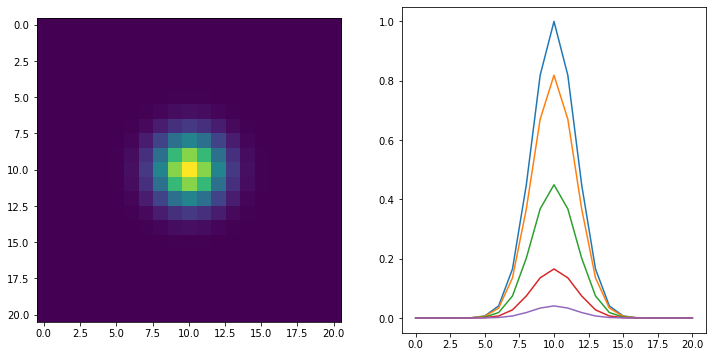

In [9]:
midy = sim_args["ny"]//2 +2 
midx = sim_args["nx"]//2 +2 
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(eta0[midy-10:midy+11,midx-10:midx+11])
for offset in range(5):
    axs[1].plot(eta0[midy-offset,midx-10:midx+11])

SU-KP without Coriolis

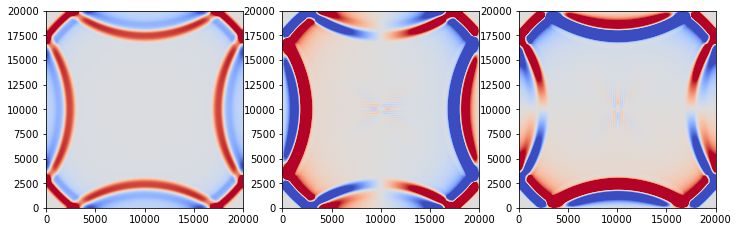

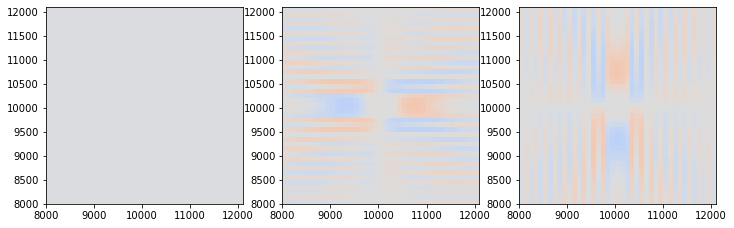

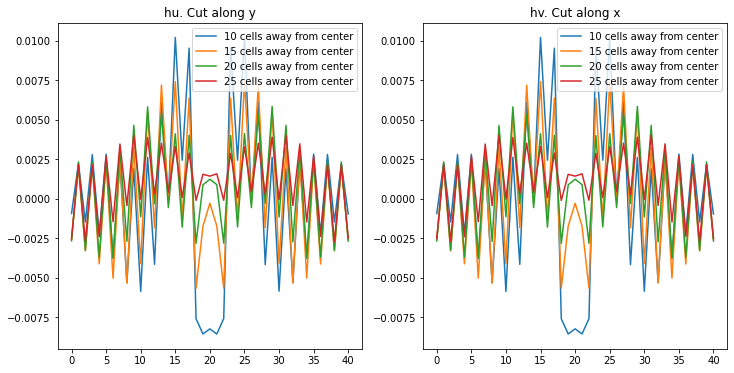

In [10]:
from importlib import reload
reload(KP07)

kp_sim = KP07.KP07(**init_args, **sim_args, dt=1.0, use_rk2=True, flux_delimiter=1.0)
sim_plotter(kp_sim, T=500, zoom=False)

kp_sim = KP07.KP07(**init_args, **sim_args, dt=1.0, use_rk2=True, flux_delimiter=1.0)
sim_plotter(kp_sim, T=500, zoom=True)
crosssecs(kp_sim)

CDKLM 

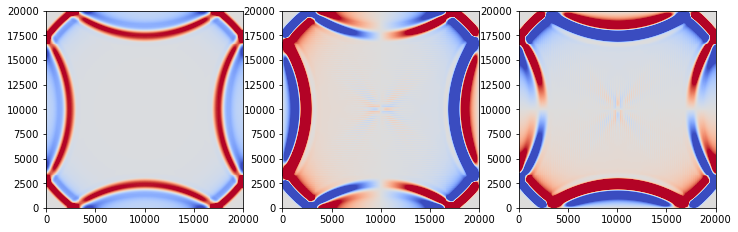

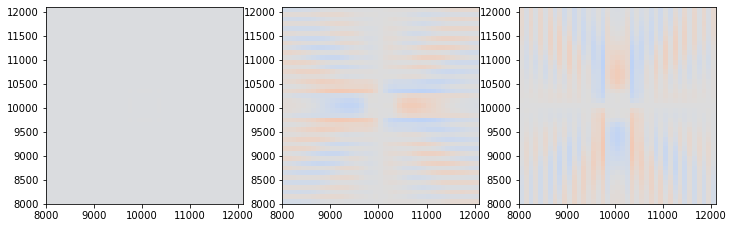

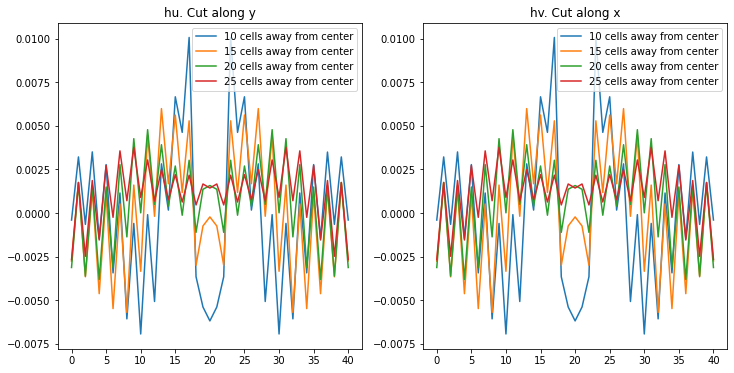

In [11]:
from importlib import reload
reload(CDKLM16)

su_sim = CDKLM16.CDKLM16(**init_args, **sim_args, dt=0.0, rk_order=2, flux_delimiter=1.0, theta=1.5)
sim_plotter(su_sim, T=500, zoom=False)

su_sim = CDKLM16.CDKLM16(**init_args, **sim_args, dt=0.0, rk_order=2, flux_delimiter=1.0, theta=1.5)
sim_plotter(su_sim, T=500, zoom=True)
crosssecs(su_sim)

CU-CDKLM

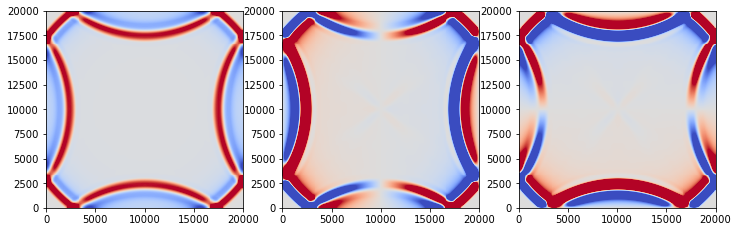

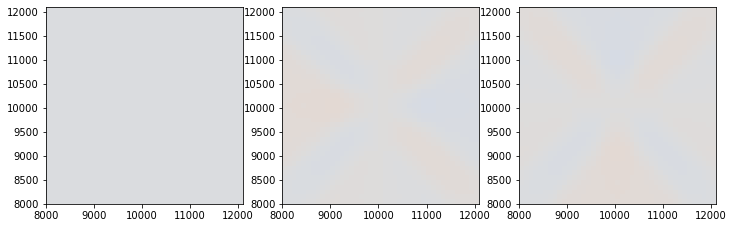

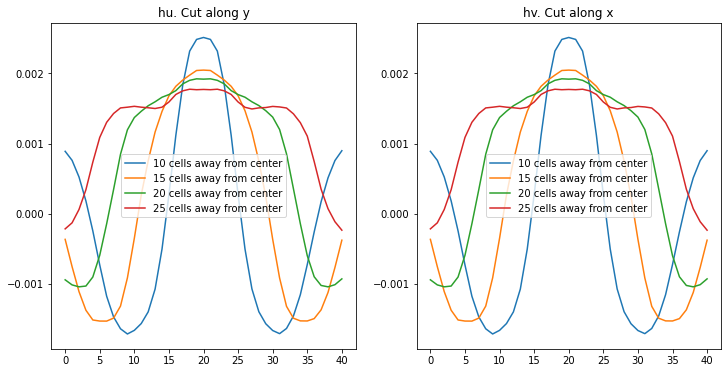

In [12]:
from importlib import reload
reload(CDKLM16)

cu_sim = CDKLM16.CDKLM16(**init_args, **sim_args, dt=0.0, rk_order=2, flux_delimiter=0.0, theta=1.5)
sim_plotter(cu_sim, T=500, zoom=False)

cu_sim = CDKLM16.CDKLM16(**init_args, **sim_args, dt=0.0, rk_order=2, flux_delimiter=0.0, theta=1.5)
sim_plotter(cu_sim, T=500, zoom=True)
crosssecs(cu_sim)

Compared

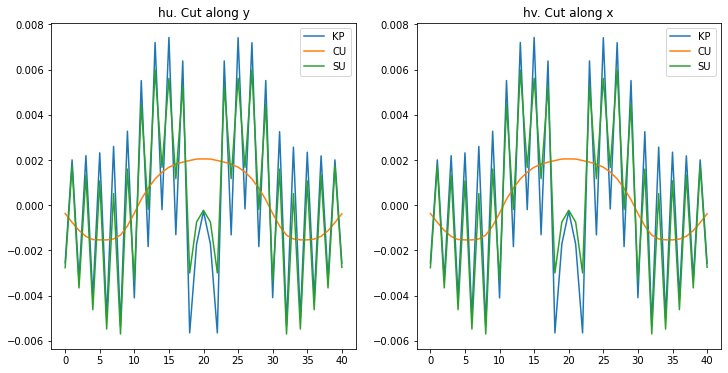

In [13]:
eta_kp, hu_kp, hv_kp = kp_sim.download(interior_domain_only=True)
eta_su, hu_su, hv_su = su_sim.download(interior_domain_only=True)
eta_cu, hu_cu, hv_cu = cu_sim.download(interior_domain_only=True)

midx = su_sim.nx//2 
midy = su_sim.ny//2 
x0, x1 = midx - 20, midx + 21
y0, y1 = midy - 20, midy + 21


fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].set_title("hu. Cut along y")
axs[1].set_title("hv. Cut along x")

axs[0].plot(hu_kp[y0:y1, midx-15], label="KP")
axs[1].plot(hv_kp[midy-15, x0:x1], label="KP")

axs[0].plot(hu_cu[y0:y1, midx-15], label="CU")
axs[1].plot(hv_cu[midy-15, x0:x1], label="CU")

axs[0].plot(hu_su[y0:y1, midx-15], label="SU")
axs[1].plot(hv_su[midy-15, x0:x1], label="SU")

axs[0].legend()
axs[1].legend()

### The problem remains independent of $dx$ and $dt$

In [14]:
# Set initial conditions common to all simulators
fine_sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 400, "ny": 400,
"dx": 50.0, "dy": 50.0,
"g": 9.81,
"f": 0.0,#0.0012,
"coriolis_beta": 0, #1.0e-6,
"r": 0.0
}

## INITIAL CONDITIONS
ghosts = np.array([2,2,2,2]) # north, east, south, west
fine_dataShape = (fine_sim_args["ny"] + ghosts[0]+ghosts[2], 
             fine_sim_args["nx"] + ghosts[1]+ghosts[3])

fine_H = np.ones((fine_dataShape[0]+1, fine_dataShape[1]+1), dtype=np.float32) * 60.0
fine_eta0 = np.zeros(fine_dataShape, dtype=np.float32)
fine_hu0 = np.zeros(fine_dataShape, dtype=np.float32)
fine_hv0 = np.zeros(fine_dataShape, dtype=np.float32)

#Create bump in to lower left of domain for testing
addCentralBump(fine_eta0, fine_sim_args["nx"], fine_sim_args["ny"], fine_sim_args["dx"], fine_sim_args["dy"], ghosts)

fine_init_args = {"H": fine_H, "eta0": fine_eta0, "hu0": fine_hu0, "hv0": fine_hv0}


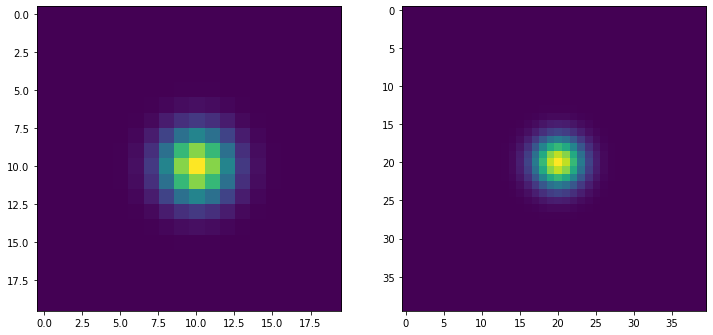

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(eta0[2:-2,2:-2][90:110,90:110])
axs[1].imshow(fine_eta0[2:-2,2:-2][180:220,180:220])

THIS DOES NOT LOOK LIKE THE SAME IC!!!

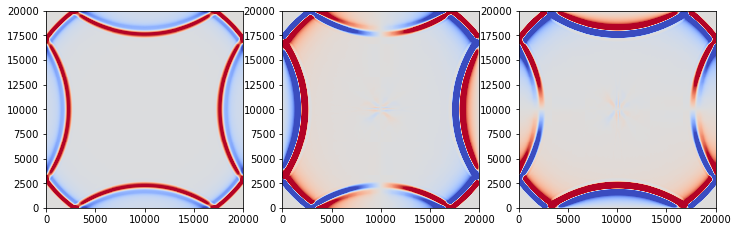

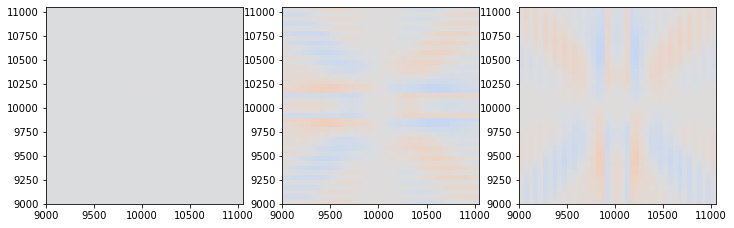

In [16]:
fine_su_sim = CDKLM16.CDKLM16(**fine_init_args, **fine_sim_args, dt=0.0, rk_order=2, flux_delimiter=1.0, theta=1.5)
sim_plotter(fine_su_sim, T=500, zoom=False)

fine_su_sim = CDKLM16.CDKLM16(**fine_init_args, **fine_sim_args, dt=0.0, rk_order=2, flux_delimiter=1.0, theta=1.5)
sim_plotter(fine_su_sim, T=500, zoom=True)

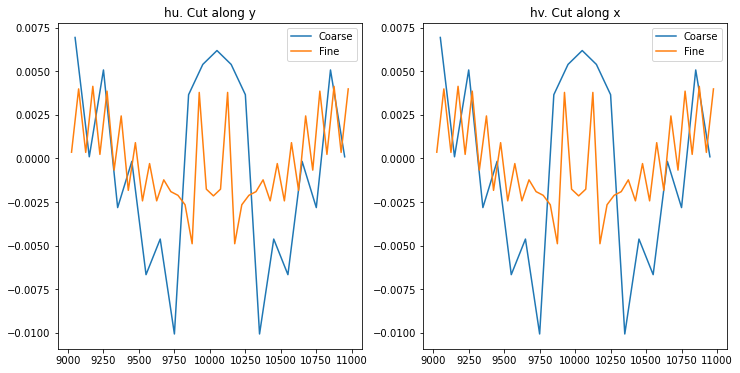

In [22]:
eta_su, hu_su, hv_su = su_sim.download(interior_domain_only=True)
fine_eta_su, fine_hu_su, fine_hv_su = fine_su_sim.download(interior_domain_only=True)


fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].set_title("hu. Cut along y")
axs[1].set_title("hv. Cut along x")


axs[0].plot(np.linspace(0.5*su_sim.dx,(su_sim.ny-0.5)*su_sim.dx,int(su_sim.nx))[90:110], hu_su[90:110, 110], label="Coarse")
axs[1].plot(np.linspace(0.5*su_sim.dx,(su_sim.ny-0.5)*su_sim.dx,int(su_sim.nx))[90:110], hv_su[110, 90:110], label="Coarse")

axs[0].plot(np.linspace(0.5*fine_su_sim.dx,(fine_su_sim.ny-0.5)*fine_su_sim.dx,int(fine_su_sim.nx))[180:220], fine_hu_su[180:220, 220], label="Fine")
axs[1].plot(np.linspace(0.5*fine_su_sim.dx,(fine_su_sim.ny-0.5)*fine_su_sim.dx,int(fine_su_sim.nx))[180:220], fine_hv_su[220, 180:220], label="Fine")

axs[0].legend()
axs[1].legend()